In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sentence_transformers.util
from opustools import OpusRead
import os
import tarfile
import gzip
import csv
from tqdm.autonotebook import tqdm
import os
import shutil


RANDOM_SEED = 42

LANGS = [
    # 'amh',
    # 'arq',
    "ary",
    "eng",
    "esp",
    "hau",
    "kin",
    "mar",
    "tel",
]

# Process Competition Data

In [2]:
def preprocess_df(df):
    if "text1" not in df.columns:
        df["text1"] = df["Text"].map(lambda x: x.split("\n")[0].strip('"'))
    if "text2" not in df.columns:
        df["text2"] = df["Text"].map(lambda x: x.split("\n")[1].strip('"'))
    df["score"] = df["Score"].map(lambda x: float(x))
    return df

In [3]:
def data_process(lang):
    train_df = pd.read_csv(f"../../data/Track A/{lang}/train_translation.csv")
    train_df['PairID'] = train_df['PairID'].astype(str)

    org_train_df = pd.read_csv(f"../../data/Track A/{lang}/{lang}_train.csv")
    org_train_df = preprocess_df(org_train_df)
    org_train_df['PairID'] = org_train_df['PairID'].astype(str)

    combined = train_df.merge(org_train_df, on="PairID", how="left")
    combined['lang'] = lang
    combined = combined[['PairID', 'text1_x', 'text2_x', 'text1_y', 'text2_y', 'Score_x', 'lang', 'model']]

    combined.rename(columns={'text1_x': 't1_src', 'text2_x': 't2_src', 'text1_y': 't1_tgt', 'text2_y': 't2_tgt', 'Score_x': 'score'}, inplace=True)

    ids = list(set(combined['PairID'].values))
    train_ids, val_ids = train_test_split(ids, test_size=0.05, random_state=RANDOM_SEED)

    train_df = combined[combined['PairID'].isin(train_ids)]
    val_df = combined[combined['PairID'].isin(val_ids)]

    df = pd.DataFrame()
    df['src'] = pd.concat([train_df['t1_src'], train_df['t2_src']])
    df['tgt'] = pd.concat([train_df['t1_tgt'], train_df['t2_tgt']])

    return train_df, val_df, df

In [22]:
all_df = []

In [23]:
for lang in LANGS:
    train_df, val_df, df = data_process(lang)

    df.to_csv(f"../../data/Track A/{lang}/train_student.tsv", sep="\t", index=False)
    val_df.to_csv(f"../../data/Track A/{lang}/val_student.tsv", sep="\t", index=False)
    print(lang)
    print(train_df.shape, val_df.shape, len(set(val_df['PairID'].values)), df.shape)
    all_df.append(df)

ary
(3156, 8) (168, 8) 42 (6312, 2)
eng
(4702, 8) (248, 8) 248 (9404, 2)
esp
(5336, 8) (284, 8) 71 (10672, 2)
hau
(5932, 8) (316, 8) 79 (11864, 2)
kin
(2660, 8) (140, 8) 35 (5320, 2)
mar
(4104, 8) (216, 8) 54 (8208, 2)
tel
(4000, 8) (212, 8) 53 (8000, 2)


In [24]:
all_df = pd.concat(all_df)

In [6]:
val_df.head()

,PairID,t1_src,t2_src,t1_tgt,t2_tgt,score,lang,model
15,TEL-train-00589,The film was a box office success.,Bollywood actor Ajay Devgn is also planning to...,ఈ సినిమా బాలీవుడ్ లో కలెక్షన్స్ బాగా తెచ్చుకుంది.,అంతేకాక ఈ షెడ్యూల్లోనే బాలీవుడ్ నటుడు అజయ్ దేవ...,0.47,tel,facebook/nllb-200-1.3B
36,TEL-train-00232,Jaycee Divakarreddhi has made harsh comments o...,"Jaycee Divakarreddhi, angry at the VCP governm...",రాష్ట్రంలో కొందరిని లక్ష్యంగా చేసుకుని కేసులు ...,వైసీపీ ప్రభుత్వంపై జేసీ దివాకర్రెడ్డి మండిపడుత...,0.65,tel,facebook/nllb-200-1.3B
37,TEL-train-01000,There are reports that theatres will be closed...,"You are the reason why I am so happy, so my jo...",ఏప్రిల్ 15 తర్వాత మళ్లీ థియేటర్ల బంద్ లేదా 50%...,నేను ఇంత ఆనందంగా ఉండటానికి కారణం నువ్వే. . అంద...,0.32,tel,facebook/nllb-200-1.3B
159,TEL-train-00979,But Shraddha Kapoor got good marks.,The Shiv Sena has decided to file another peti...,కానీ శ్రధ్ధా కపూర్ నటకు మాత్రం మంచి మార్కులు ప...,"రాష్టప్రతి పాలనకు గవర్నర్ సిఫార్సు చేయడం, కేంద...",0.34,tel,facebook/nllb-200-1.3B
169,TEL-train-00068,Too much fun took the life of a young man.,The young man died from too much fun.,మితిమీరిన సరదా ఓ యువకుడి ప్రాణం తీసింది .,అతి సరదా వల్ల యువకుడు చనిపోయాడు.,0.75,tel,facebook/nllb-200-1.3B


In [7]:
df.head()

,src,tgt
0,Producer K.K. Radhamohan is preparing to relea...,అన్ని కార్యక్రమాలు పూర్తిచేసి ఈ చిత్రాన్ని ఈనె...
1,"Speaking on the occasion, Zonal CPM Secretary ...",ఈ సందర్భంగా మండల సిపిఎం కార్యదర్శి వెల్లంపల్లి...
2,The police have registered a case and are inve...,ఈ మేరకు కేసు నమోదు చేసుకున్న పోలీసులు దర్యాప్త...
3,A cargo plane crashed into the sea off the Ivo...,సరుకులు తీసుకువెళ్తున్న ఓ కార్గో విమానం సముద్ర...
4,"With this, Windy scored 183 runs for the loss ...",దీంతో విండీస్ 18.1 ఓవర్లలో 4 వికెట్ల నష్టానికి...


<AxesSubplot:>

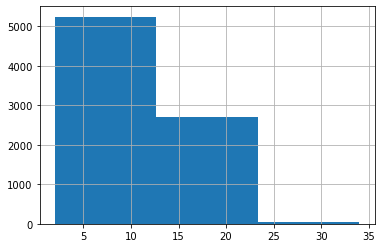

In [20]:
df['tgt'].map(lambda x: len(x.split())).hist(bins=3)

In [11]:
source_languages = set(["en"])  # Our teacher model accepts English (en) sentences
target_languages = set(
    # all needed: 
    ['arq', 'amh', 'am', 'ha', 'hau', 'kin', 'rw', 'mr', 'ary', 'es', 'te']
    # needed: ['arq', 'am', 'ha', 'rw', 'mr', 'ary', 'es', 'te']
    # available:
    # ['arq', 'am', 'ha', 'mr', 'es', 'te']
    # ["de", "es", "it", "fr", "ar", "tr"]
)  # We want to extend the model to these new languages. For language codes, see the header of the train file

# Get Talks data

In [12]:
dev_sentences = 1000  # Number of sentences we want to use for development
download_url = "https://sbert.net/datasets/parallel-sentences.tsv.gz"  # Specify parallel sentences URL here

parallel_sentences_path = "./talks/talks.tsv.gz"  # Path of the parallel-sentences.tsv.gz file.
parallel_sentences_folder = "../../data/student/talks/"


os.makedirs(os.path.dirname(parallel_sentences_path), exist_ok=True)
if not os.path.exists(parallel_sentences_path):
    print("parallel-sentences.tsv.gz does not exists. Try to download from server")
    sentence_transformers.util.http_get(download_url, parallel_sentences_path)


os.makedirs(parallel_sentences_folder, exist_ok=True)
train_files = []
dev_files = []
files_to_create = []
for source_lang in source_languages:
    for target_lang in target_languages:
        output_filename_train = os.path.join(
            parallel_sentences_folder, "talks-{}-{}-train.tsv.gz".format(source_lang, target_lang)
        )
        output_filename_dev = os.path.join(
            parallel_sentences_folder, "talks-{}-{}-dev.tsv.gz".format(source_lang, target_lang)
        )
        train_files.append(output_filename_train)
        dev_files.append(output_filename_dev)
        if not os.path.exists(output_filename_train) or not os.path.exists(output_filename_dev):
            files_to_create.append(
                {
                    "src_lang": source_lang,
                    "trg_lang": target_lang,
                    'fTrain': output_filename_train,
                    'fDev': output_filename_dev,
                    "devCount": 0,
                }
            )

if len(files_to_create) > 0:
    print(
        "Parallel sentences files {} do not exist. Create these files now".format(
            ", ".join(map(lambda x: x["src_lang"] + "-" + x["trg_lang"], files_to_create))
        )
    )
    for outfile in files_to_create:
        try:
            with gzip.open(parallel_sentences_path, "rt", encoding="utf8") as fIn:
                reader = csv.DictReader(fIn, delimiter="\t", quoting=csv.QUOTE_NONE)
                flg = 0
                for line in tqdm(reader, desc="Sentences"):
                    src_text = line[outfile["src_lang"]].strip()
                    trg_text = line[outfile["trg_lang"]].strip()

                    if flg == 0:
                        outfile["fTrain"] = gzip.open(outfile["fTrain"], "wt", encoding="utf8")
                        outfile["fDev"] = gzip.open(outfile["fDev"], "wt", encoding="utf8")
                        flg = 1

                    if src_text != "" and trg_text != "":
                        if outfile["devCount"] < dev_sentences:
                            outfile["devCount"] += 1
                            fOut = outfile["fDev"]
                        else:
                            fOut = outfile["fTrain"]

                        fOut.write("{}\t{}\n".format(src_text, trg_text))
        except Exception as e:
            print(outfile, e)

    for outfile in files_to_create:
        try:
            outfile["fTrain"].close()
            outfile["fDev"].close()
        except Exception as e:
            print(outfile, e)

shutil.rmtree("./talks/")
print("---DONE---")

parallel-sentences.tsv.gz does not exists. Try to download from server


  0%|          | 0.00/581M [00:00<?, ?B/s]

Parallel sentences files en-rw, en-kin, en-hau, en-ary, en-amh do not exist. Create these files now


Sentences: 0it [00:00, ?it/s]

{'src_lang': 'en', 'trg_lang': 'rw', 'fTrain': '../../data/student/talks/talks-en-rw-train.tsv.gz', 'fDev': '../../data/student/talks/talks-en-rw-dev.tsv.gz', 'devCount': 0} 'rw'


Sentences: 0it [00:00, ?it/s]

{'src_lang': 'en', 'trg_lang': 'kin', 'fTrain': '../../data/student/talks/talks-en-kin-train.tsv.gz', 'fDev': '../../data/student/talks/talks-en-kin-dev.tsv.gz', 'devCount': 0} 'kin'


Sentences: 0it [00:00, ?it/s]

{'src_lang': 'en', 'trg_lang': 'hau', 'fTrain': '../../data/student/talks/talks-en-hau-train.tsv.gz', 'fDev': '../../data/student/talks/talks-en-hau-dev.tsv.gz', 'devCount': 0} 'hau'


Sentences: 0it [00:00, ?it/s]

{'src_lang': 'en', 'trg_lang': 'ary', 'fTrain': '../../data/student/talks/talks-en-ary-train.tsv.gz', 'fDev': '../../data/student/talks/talks-en-ary-dev.tsv.gz', 'devCount': 0} 'ary'


Sentences: 0it [00:00, ?it/s]

{'src_lang': 'en', 'trg_lang': 'amh', 'fTrain': '../../data/student/talks/talks-en-amh-train.tsv.gz', 'fDev': '../../data/student/talks/talks-en-amh-dev.tsv.gz', 'devCount': 0} 'amh'
{'src_lang': 'en', 'trg_lang': 'rw', 'fTrain': '../../data/student/talks/talks-en-rw-train.tsv.gz', 'fDev': '../../data/student/talks/talks-en-rw-dev.tsv.gz', 'devCount': 0} 'str' object has no attribute 'close'
{'src_lang': 'en', 'trg_lang': 'kin', 'fTrain': '../../data/student/talks/talks-en-kin-train.tsv.gz', 'fDev': '../../data/student/talks/talks-en-kin-dev.tsv.gz', 'devCount': 0} 'str' object has no attribute 'close'
{'src_lang': 'en', 'trg_lang': 'hau', 'fTrain': '../../data/student/talks/talks-en-hau-train.tsv.gz', 'fDev': '../../data/student/talks/talks-en-hau-dev.tsv.gz', 'devCount': 0} 'str' object has no attribute 'close'
{'src_lang': 'en', 'trg_lang': 'ary', 'fTrain': '../../data/student/talks/talks-en-ary-train.tsv.gz', 'fDev': '../../data/student/talks/talks-en-ary-dev.tsv.gz', 'devCount': 0

# Get WikiMatrix

In [13]:
num_dev_sentences = 1000  # Number of sentences we want to use for development
threshold = 1.075  # Only use sentences with a LASER similarity score above the threshold

download_url = "https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/"
download_folder = "./WikiMatrix/"
parallel_sentences_folder = "../../data/student/WikiMatrix/"


os.makedirs(os.path.dirname(download_folder), exist_ok=True)
os.makedirs(parallel_sentences_folder, exist_ok=True)


for source_lang in source_languages:
    for target_lang in target_languages:
        filename_train = os.path.join(
            parallel_sentences_folder, "WikiMatrix-{}-{}-train.tsv.gz".format(source_lang, target_lang)
        )
        filename_dev = os.path.join(
            parallel_sentences_folder, "WikiMatrix-{}-{}-dev.tsv.gz".format(source_lang, target_lang)
        )

        if not os.path.exists(filename_train) and not os.path.exists(filename_dev):
            langs_ordered = sorted([source_lang, target_lang])
            wikimatrix_filename = "WikiMatrix.{}-{}.tsv.gz".format(*langs_ordered)
            wikimatrix_filepath = os.path.join(download_folder, wikimatrix_filename)

            if not os.path.exists(wikimatrix_filepath):
                print("Download", download_url + wikimatrix_filename)
                try:
                    sentence_transformers.util.http_get(download_url + wikimatrix_filename, wikimatrix_filepath)
                except Exception:
                    print("Was not able to download", download_url + wikimatrix_filename)
                    continue

            if not os.path.exists(wikimatrix_filepath):
                continue

            train_sentences = []
            dev_sentences = []
            dev_sentences_set = set()
            extract_dev_sentences = True

            with gzip.open(wikimatrix_filepath, "rt", encoding="utf8") as fIn:
                for line in fIn:
                    score, sent1, sent2 = line.strip().split("\t")
                    sent1 = sent1.strip()
                    sent2 = sent2.strip()
                    score = float(score)

                    if score < threshold:
                        break

                    if sent1 == sent2:
                        continue

                    if langs_ordered.index(source_lang) == 1:  # Swap, so that src lang is sent1
                        sent1, sent2 = sent2, sent1

                    # Avoid duplicates in development set
                    if sent1 in dev_sentences_set or sent2 in dev_sentences_set:
                        continue

                    if extract_dev_sentences:
                        dev_sentences.append([sent1, sent2])
                        dev_sentences_set.add(sent1)
                        dev_sentences_set.add(sent2)

                        if len(dev_sentences) >= num_dev_sentences:
                            extract_dev_sentences = False
                    else:
                        train_sentences.append([sent1, sent2])

            print("Write", len(dev_sentences), "dev sentences", filename_dev)
            with gzip.open(filename_dev, "wt", encoding="utf8") as fOut:
                for sents in dev_sentences:
                    fOut.write("\t".join(sents))
                    fOut.write("\n")

            print("Write", len(train_sentences), "train sentences", filename_train)
            with gzip.open(filename_train, "wt", encoding="utf8") as fOut:
                for sents in train_sentences:
                    fOut.write("\t".join(sents))
                    fOut.write("\n")


shutil.rmtree("./WikiMatrix/")
print("---DONE---")

Download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.arq-en.tsv.gz


Exception when trying to download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.arq-en.tsv.gz. Response 403


Was not able to download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.arq-en.tsv.gz
Download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.en-rw.tsv.gz


Exception when trying to download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.en-rw.tsv.gz. Response 403


Was not able to download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.en-rw.tsv.gz
Download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.en-kin.tsv.gz


Exception when trying to download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.en-kin.tsv.gz. Response 403


Was not able to download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.en-kin.tsv.gz
Download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.en-hau.tsv.gz


Exception when trying to download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.en-hau.tsv.gz. Response 403


Was not able to download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.en-hau.tsv.gz
Download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.am-en.tsv.gz


Exception when trying to download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.am-en.tsv.gz. Response 403


Was not able to download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.am-en.tsv.gz
Download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.en-ha.tsv.gz


Exception when trying to download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.en-ha.tsv.gz. Response 403


Was not able to download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.en-ha.tsv.gz
Download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.ary-en.tsv.gz


Exception when trying to download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.ary-en.tsv.gz. Response 403


Was not able to download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.ary-en.tsv.gz
Download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.amh-en.tsv.gz
Was not able to download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.amh-en.tsv.gz
---DONE---


Exception when trying to download https://dl.fbaipublicfiles.com/laser/WikiMatrix/v1/WikiMatrix.amh-en.tsv.gz. Response 403


# Get Tatoeba

In [14]:
# Note: Tatoeba uses 3 letter languages codes (ISO-639-2),
# while other datasets like OPUS use 2 letter language codes (ISO-639-1)
# For training of sentence transformers, which type of language code is used doesn't matter.
# For language codes, see: https://en.wikipedia.org/wiki/List_of_ISO_639-2_codes
source_languages_3 = set(["eng"])
target_languages_3 = set(["amh", "hau", "kin", "mar", "spa", "tel"])

num_dev_sentences = 1000  # Number of sentences that are used to create a development set


tatoeba_folder = "./tatoeba"
output_folder = "../../data/student/tatoeba/"


sentences_file_bz2 = os.path.join(tatoeba_folder, "sentences.tar.bz2")
sentences_file = os.path.join(tatoeba_folder, "sentences.csv")
links_file_bz2 = os.path.join(tatoeba_folder, "links.tar.bz2")
links_file = os.path.join(tatoeba_folder, "links.csv")

download_url = "https://downloads.tatoeba.org/exports/"


os.makedirs(tatoeba_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

# Download files if needed
for filepath in [sentences_file_bz2, links_file_bz2]:
    if not os.path.exists(filepath):
        url = download_url + os.path.basename(filepath)
        print("Download", url)
        sentence_transformers.util.http_get(url, filepath)

# Extract files if needed
if not os.path.exists(sentences_file):
    print("Extract", sentences_file_bz2)
    tar = tarfile.open(sentences_file_bz2, "r:bz2")
    tar.extract("sentences.csv", path=tatoeba_folder)
    tar.close()

if not os.path.exists(links_file):
    print("Extract", links_file_bz2)
    tar = tarfile.open(links_file_bz2, "r:bz2")
    tar.extract("links.csv", path=tatoeba_folder)
    tar.close()


# Read sentences
sentences = {}
all_langs = target_languages_3.union(source_languages_3)
print("Read sentences.csv file")
with open(sentences_file, encoding="utf8") as fIn:
    for line in fIn:
        id, lang, sentence = line.strip().split("\t")
        if lang in all_langs:
            sentences[id] = (lang, sentence)

# Read links that map the translations between different languages
print("Read links.csv")
translations = {src_lang: {trg_lang: {} for trg_lang in target_languages_3} for src_lang in source_languages_3}
with open(links_file, encoding="utf8") as fIn:
    for line in fIn:
        src_id, target_id = line.strip().split()

        if src_id in sentences and target_id in sentences:
            src_lang, src_sent = sentences[src_id]
            trg_lang, trg_sent = sentences[target_id]

            if src_lang in source_languages_3 and trg_lang in target_languages_3:
                if src_sent not in translations[src_lang][trg_lang]:
                    translations[src_lang][trg_lang][src_sent] = []
                translations[src_lang][trg_lang][src_sent].append(trg_sent)

# Write everything to the output folder
print("Write output files")
for src_lang in source_languages_3:
    for trg_lang in target_languages_3:
        source_sentences = list(translations[src_lang][trg_lang])
        train_sentences = source_sentences[num_dev_sentences:]
        dev_sentences = source_sentences[0:num_dev_sentences]

        print("{}-{} has {} sentences".format(src_lang, trg_lang, len(source_sentences)))
        if len(dev_sentences) > 0:
            with gzip.open(
                os.path.join(output_folder, "Tatoeba-{}-{}-dev.tsv.gz".format(src_lang, trg_lang)),
                "wt",
                encoding="utf8",
            ) as fOut:
                for sent in dev_sentences:
                    fOut.write("\t".join([sent] + translations[src_lang][trg_lang][sent]))
                    fOut.write("\n")

        if len(train_sentences) > 0:
            with gzip.open(
                os.path.join(output_folder, "Tatoeba-{}-{}-train.tsv.gz".format(src_lang, trg_lang)),
                "wt",
                encoding="utf8",
            ) as fOut:
                for sent in train_sentences:
                    fOut.write("\t".join([sent] + translations[src_lang][trg_lang][sent]))
                    fOut.write("\n")

shutil.rmtree("./tatoeba/")
print("---DONE---")

Download https://downloads.tatoeba.org/exports/sentences.tar.bz2


  0%|          | 0.00/187M [00:00<?, ?B/s]

Download https://downloads.tatoeba.org/exports/links.tar.bz2


  0%|          | 0.00/126M [00:00<?, ?B/s]

Extract ./tatoeba/sentences.tar.bz2
Extract ./tatoeba/links.tar.bz2
Read sentences.csv file
Read links.csv
Write output files
eng-tel has 280 sentences
eng-kin has 19 sentences
eng-hau has 21867 sentences
eng-spa has 226989 sentences
eng-amh has 194 sentences
eng-mar has 48758 sentences
---DONE---


# Get OPUS Data

In [10]:
# Run it through opus.py, as notebook hangs when running it

# corpora = [
#     "NLLB",
#     "QED",
#     "TED2020 v1"
# ]  # Corpora you want to use

# output_folder = "../../data/student/"
# opus_download_folder = "./opus"

# # Iterator over all corpora / source languages / target languages combinations and download files
# os.makedirs(output_folder, exist_ok=True)

# for corpus in corpora:
#     for src_lang in source_languages:
#         for trg_lang in target_languages:
#             corpus_folder = os.path.join(output_folder, corpus)
#             os.makedirs(corpus_folder, exist_ok=True)
#             output_filename = os.path.join(output_folder, corpus, "OPUS-{}-{}-train.tsv.gz".format(src_lang, trg_lang))
#             if not os.path.exists(output_filename):
#                 print("Create:", output_filename)
#                 try:
#                     read = OpusRead(
#                         directory=corpus,
#                         source=src_lang,
#                         target=trg_lang,
#                         write=[output_filename],
#                         download_dir=opus_download_folder,
#                         preprocess="raw",
#                         write_mode="moses",
#                         suppress_prompts=True,
#                         verbose=True,
#                     )
#                     read.printPairs()
#                 except Exception as e:
#                     print("error:", output_filename, e)
#                     os.remove(output_filename)

# shutil.rmtree("./opus/")
# print("---DONE---")

# Combine and Balance Data

In [ ]:
lang_code_1toN = {
    "arq": ["arq"],
    "am": ["am", "amh"],
    "en": ["eng", "en"],
    "ha": ["ha", "hau"],
    "kin": ["rw", "kin"],
    "mr": ["mr"],
    "ary": ["ary"],
    "es": ["es", 'spa'],
    "te": ["te"],
}
lang_code_Nto1 = {}
for k, v in lang_code_1toN.items():
    for v_ in v:
        lang_code_Nto1[v_] = k